In [1]:
import sys
from gurobipy import *
import numpy
import random
import math
import time
import pandas as pd

ModuleNotFoundError: No module named 'gurobipy'

In [51]:
def gurobiSolve(name1, name2, name, social, ratio):
    with open(name1 + name2 + name + '.txt') as f:
        numc = int(next(f).split()[0])
        nump1 = int(next(f).split()[0])
        nump2 = int(next(f).split()[0])
        numvr = int(next(f).split()[0])
        numnr = int(next(f).split()[0])
        numhr = int(next(f).split()[0])
        nump = nump1 + nump2
    
        data = []
        for line in f:
            data.append([float(x) for x in line.split()])
        
    txt3 = []
    xc = []
    yc = []
    fee = []
    for c in range(numc):
        txt3.append(int(data[c][0]))
        xc.append(data[c][1])
        yc.append(data[c][2])
        fee.append(data[c][3])
    
    salary_vr = []
    for vr in range(numvr):
        salary_vr.append(data[numc + vr][2])

    salary_nr = []
    for nr in range(numnr):
        salary_nr.append(data[numc + numvr + nr][2])

    salary_hr = []
    for hr in range(numhr):
        salary_hr.append(data[numc + numvr + numnr + hr][2])
        
    cur_index = numc + numvr + numnr + numhr
    
    txt1 = []
    p1_x = []
    p1_y = []
    p1_st = []
    p1_ser = []
    p1_ed = []

    for p1 in range(nump1):
        txt1.append(int(data[cur_index + p1][0]))
        p1_x.append(data[cur_index + p1][2])
        p1_y.append(data[cur_index + p1][3])
        p1_ser.append(data[cur_index + p1][4])
        p1_st.append(data[cur_index + p1][5])
        p1_ed.append(data[cur_index + p1][6])

    txt2 = []
    p2_x = []
    p2_y = []
    p2_st = []
    p2_ser = []
    p2_ed = []

    cur_index += nump1;
    for p1 in range(nump2):
        txt2.append(int(data[cur_index + p1][0]))
        p2_x.append(data[cur_index + p1][2])
        p2_y.append(data[cur_index + p1][3])
        p2_ser.append(data[cur_index + p1][4])
        p2_st.append(data[cur_index + p1][5])
        p2_ed.append(data[cur_index + p1][6])

    px = p1_x + p2_x
    py = p1_y + p2_y
    st = p1_st + p2_st
    ed = p1_ed + p2_ed
    ser = p1_ser + p2_ser

    pcx = px + xc
    pcy = py + yc
    
    numc1 = numc - 1
                    
    plot(p1_x, p1_y, txt1, p2_x, p2_y, txt2, xc, yc, txt3, name1, name)
    
    def travel(j1, j2):
        return (((px[j1] - px[j2])**2 + (py[j1] - py[j2])**2)**0.5*0.02)

    def travelc(j1, j2):
        return (((pcx[j1] - pcx[j2])**2 + (pcy[j1] - pcy[j2])**2)**0.5*2.2)
    
    def travelp(i, j):
        if social == True:
            if ratio == True:
                return (((px[j] - xc[i])**2 + (py[j] - yc[i])**2)**0.5*2.8)
            else:
                return (((px[j] - xc[i])**2 + (py[j] - yc[i])**2)**0.5*1.5)
        else:
            return 0
    
    mo = Model("nvrp")
    z = {}
    for i in range(numc): # include hospital
        z[i] = mo.addVar(vtype = GRB.BINARY, name="z[%s]" %(i))

    p1 = {}
    for i in range(numc):
        for k in range(numvr):
            p1[i, k] = mo.addVar(vtype = GRB.BINARY, name="p1[%s,%s]" %(i,k))

    p2 = {}
    for i in range(numc):
        for k in range(numnr):
            p2[i, k] = mo.addVar(vtype = GRB.BINARY, name="p2[%s,%s]" %(i,k))   

    p3 = {}
    for i in range(numhr):
        p3[i] = mo.addVar(vtype = GRB.BINARY, name="p3[%s]" %(i))  

    w1 = {}
    for i in range(numc):
        for j in range(nump):
            for k in range(numvr):
                w1[i, j, k] = mo.addVar(vtype = GRB.BINARY, name="w1[%s,%s,%s]" %(i,j,k))

    w2 = {}
    for i in range(numc):
        for j in range(nump):
            for k in range(numnr):
                w2[i, j, k] = mo.addVar(vtype = GRB.BINARY, name="w2[%s,%s,%s]" %(i,j,k))

    w3 = {}
    for j in range(nump):
        for k in range(numhr):
            w3[j, k] = mo.addVar(vtype = GRB.BINARY, name="w3[%s,%s]" %(j,k))
        
    s1 = {}
    for j in range(nump):
        for k in range(numvr):
            s1[j, k] = mo.addVar(lb = st[j], ub = ed[j], vtype = GRB.CONTINUOUS, name="s1[%s,%s]" %(j,k))

    s2 = {}
    for j in range(nump):
        for k in range(numnr):
            s2[j, k] = mo.addVar(lb = st[j], ub = ed[j], vtype = GRB.CONTINUOUS, name="s2[%s,%s]" %(j,k))

    s3 = {}
    for j in range(nump):
        for k in range(numvr):
            s3[j, k] = mo.addVar(lb = st[j], ub = ed[j], vtype = GRB.CONTINUOUS, name="s3[%s,%s]" %(j,k))


    x1 = {}
    for i in range(numc):
        for j1 in range(nump + numc):
            for j2 in range(nump + numc):
                for k in range(numvr):
                    x1[i, j1, j2, k] = mo.addVar(vtype = GRB.BINARY, name="x1[%s,%s,%s,%s]" %(i,j1,j2,k))

    x2 = {}
    for i in range(numc):
        for j1 in range(nump + numc):
            for j2 in range(nump + numc):
                for k in range(numnr):
                    x2[i, j1, j2, k] = mo.addVar(vtype = GRB.BINARY, name="x2[%s,%s,%s,%s]" %(i,j1,j2,k))

    x3 = {}
    for j1 in range(nump+1):
        for j2 in range(nump+1):
            for k in range(numhr):
                x3[j1, j2, k] = mo.addVar(vtype = GRB.BINARY, name="x3[%s,%s,%s]" %(j1,j2,k))
                
    for k in range(numvr): # i = hospital
        mo.addConstr(p1[numc, k] == 0)          
    for k in range(numnr):
        mo.addConstr(p2[numc, k] == 0)
        
    
    for j in range(nump1): # j1 type nr, hr = 0
        for k in range(numnr):
            for i in range(numc):
                mo.addConstr(w2[i, j, k] == 0)
        for k in range(numhr):
            mo.addConstr(w3[j, k] == 0)
            
    for i in range(numc):
        for j1 in range(nump1):
            for j2 in range(nump + numc):
                for k in range(numnr): # j1 -> all
                    mo.addConstr(x2[i, j1, j2, k] == 0)
        for j1 in range(nump1 + numc):
            for j2 in range(nump1):
                for k in range(numnr): # all -> j1
                    mo.addConstr(x2[i, j1, j2, k] == 0)    
                    
    for j1 in range(nump1):
        for j2 in range(nump + numc):
            for k in range(numhr): #j1 -> all
                mo.addConstr(x3[j1, j2, k] == 0)
    for j1 in range(nump1 + numc):
        for j2 in range(nump1):
            for k in range(numhr): # all -> j1
                mo.addConstr(x3[j1, j2, k] == 0)  
                
    for j1 in range(numc1):
        for j2 in range(nump + numc1):
            for k in range(numhr): # c -> all
                mo.addConstr(x3[nump + j1, j2, k] == 0)
    
    for j1 in range(numc1):
        for j2 in range(nump + numc1):
            for k in range(numhr): # c -> all
                mo.addConstr(x3[j1, nump + j2, k] == 0)         
    
    
    

    cc = {}
    cc[0] = {}
    

    for j2 in range(nump2):
        temp = 0
        for i in range(numc1):
            for k in range(numvr):
                temp += w1[i, nump1 + j2, k]
        for i in range(numc1):
            for k in range(numnr):
                temp += w2[i, nump1 + j2, k]
        for k in range(numhr):
            temp += w3[nump1 + j2, k]
        cc[0][j2] = mo.addConstr(temp == 1, name="c0_[%s]" %(j2))

    cc[1] = {}
    for j1 in range(nump1):
        temp = 0
        for i in range(numc1):
            for k in range(numvr):
                temp += w1[i, j1, k]
        cc[1][j1] = mo.addConstr(temp == 1, name="c1_[%s]" %(j1))

    cc[2] = {}
    for k in range(numvr):
        temp = 0
        for i in range(numc1):
            temp += p1[i, k]
        cc[2][k] = mo.addConstr(temp <= 1, name="c2_[%s]" %(k))

    cc[3] = {}
    for k in range(numnr):
        temp = 0
        for i in range(numc1):
            temp += p2[i, k]
        cc[3][k] = mo.addConstr(temp <= 1, name="c3_[%s]" %(k))

k
    cc[4] = {}
    for k in range(numhr):
        cc[4][k] = mo.addConstr(p3[k] <= 1, name="c4_[%s]" %(k))

    cc[5] = {}
    for i in range(numc1):
        for k in range(numvr):
            cc[5][i, k] = mo.addConstr(p1[i, k] <= z[i], name="c5_[%s,%s]" %(i, k))

    cc[6] = {}
    for i in range(numc1):
        for k in range(numnr):
            cc[6][i, k] = mo.addConstr(p2[i, k] <= z[i],  name="c6_[%s,%s]" %(i, k))

    cc[7] = {}
    for i in range(numc1):
        for j in range(nump):
            for k in range(numvr):
                cc[7][i, j, k] = mo.addConstr(w1[i, j, k] <= p1[i, k], name="c7_[%s,%s,%s]" %(i, j, k))

    cc[8] = {}
    for i in range(numc1):
        for j in range(nump1, nump):
            for k in range(numnr):
                cc[8][i, j, k] = mo.addConstr(w2[i, j, k] <= p2[i, k], name="c8_[%s,%s,%s]" %(i, j, k))   

    cc[9] = {}
    for j in range(nump1, nump):
        for k in range(numhr):
            cc[9][j, k] = mo.addConstr(w3[j, k] <= p3[k], name="c9_[%s,%s]" %(j, k))

    #cc[10] = {}
    #for i in range(numc1):
    #    for k in range(numnr):
    #        temp = 0
    #        for j in range(nump2):
    #            temp += p2_ser[j] * w2[i, nump1 + j, k]
    #        cc[10][i, k] = mo.addConstr(temp <= 10, name="c10_[%s,%s]" %(i, k))


    #cc[11] = {}
    #for k in range(numhr):
    #    temp = 0
    #    for j in range(nump2):
    #        temp += p2_ser[j] * w3[nump1 + j, k]
    #    cc[11][k] = mo.addConstr(temp <= 10, name="c11_[%s,%s]" %(j, k))


    cc[12] = {}
    for i in range(numc1):
        for j1 in range(nump):
            for k in range(numvr):
                temp = 0
                for j2 in range(nump + numc1):
                    if j2 != j1:
                        temp += x1[i, j1, j2, k]
                cc[12][i, j1, j2, k] = mo.addConstr(temp == w1[i, j1, k], name="c12_[%s,%s,%s,%s]" %(i, j1, j2, k))


    cc[121] = {}
    for i in range(numc1):
        for j1 in range(nump):
            for k in range(numvr):
                temp = 0
                for j2 in range(nump + numc1):
                    if j2 != j1:
                        temp += x1[i, j2, j1, k]
                cc[121][i, j1, j2, k] = mo.addConstr(temp == w1[i, j1, k], name="c121_[%s,%s,%s,%s]" %(i, j1, j2, k))            


    cc[13] = {}
    for i in range(numc1):
        for j1 in range(nump1, nump):
            for k in range(numnr):
                temp = 0
                for j2 in range(nump1, nump + numc1):
                    if j2 != j1:
                        temp += x2[i, j1, j2, k]
                cc[13][i, j1, j2, k] = mo.addConstr(temp == w2[i, j1, k], name="c13_[%s,%s,%s,%s]" %(i, j1, j2, k))


    cc[131] = {}
    for i in range(numc1):
        for j1 in range(nump1, nump):
            for k in range(numnr):
                temp = 0
                for j2 in range(nump1, nump + numc1):
                    if j2 != j1:
                        temp += x2[i, j2, j1, k]
                cc[131][i, j1, j2, k] = mo.addConstr(temp == w2[i, j1, k], name="c131_[%s,%s,%s,%s]" %(i, j1, j2, k))


    # set 0
    #for i in range(numc):
    #    for j1 in range(nump, nump + numc):
    #        for j2 in range(nump, nump + numc):
    #            for k in range(numnr):            
    #                mo.addConstr(x2[i, j1, j2, k] == 0)


    cc[14] = {}
    for j1 in range(nump1, nump):
        for k in range(numhr):
            temp = 0
            for j2 in range(nump1, nump+1):
                if j2 != j1:
                    temp += x3[j1, j2, k]
            cc[14][j1, j2, k] = mo.addConstr(temp == w3[j1, k], name="c14_[%s,%s,%s]" %(j1, j2, k))

    cc[141] = {}
    for j1 in range(nump1, nump):
        for k in range(numhr):
            temp = 0
            for j2 in range(nump1, nump+1):
                if j2 != j1:
                    temp += x3[j2, j1, k]
            cc[141][j1, j2, k] = mo.addConstr(temp == w3[j1, k], name="c141_[%s,%s,%s]" %(j1, j2, k))


    cc[15] = {}
    for i in range(numc1):
        for k in range(numvr):
            for j in range(nump):
                temp1 = x1[i, nump + i, j, k] # depot
                temp2 = x1[i, j, nump + i, k] # depot
                for j1 in range(nump):
                    if j1 != j:
                        temp1 += x1[i, j1, j, k]
                for j2 in range(nump):
                    if j2 != j:
                        temp2 += x1[i, j, j2, k]
                cc[15][i, j, k] = mo.addConstr(temp1 == temp2, name="c15_[%s,%s,%s]" %(i, j, k))       

    cc[16] = {}
    for i in range(numc1):
        for k in range(numnr):
            for j in range(nump1, nump):
                temp1 = x2[i, nump + i, j, k]
                temp2 = x2[i, j, nump + i, k]
                for j1 in range(nump1, nump):
                    if j1 != j:
                        if j1 !=j:
                            temp1 += x2[i, j1, j, k]
                for j2 in range(nump1, nump):
                    if j2 != j:
                        if j2 != j:
                            temp2 += x2[i, j, j2, k]
                cc[16][i, j, k] = mo.addConstr(temp1 == temp2, name="c16_[%s,%s,%s]" %(i, j, k))   


    cc[17] = {}
    for k in range(numhr):
        for j in range(nump1, nump):
            temp1 = x3[nump + numc - 1, j, k]
            temp2 = x3[j, nump + numc - 1, k]
            for j1 in range(nump1, nump):
                if j1 != j:
                    temp1 += x3[j1, j, k]
            for j2 in range(nump1, nump):
                if j2 != j:
                    temp2 += x3[j, j2, k]
            cc[17][j, k] = mo.addConstr(temp1 == temp2, name="c17_[%s,%s]" %(j, k))  
        
        for j1 in range(nump1, nump):
            if j1 != j:
                temp11 += x3[j1, nump + numc1 - 1, k]
        for j2 in range(nump1, nump):
            if j2 != j:
                temp22 += x3[nump + numc1 - 1, j2, k]
        cc[17][nump1 + numc - 1, k] = mo.addConstr(temp11 == temp22, name="c17_[%s,%s]" %(nump + numc - 1, k)) 

    cc[18] = {} # depot in flow = out flow
    cc[19] = {}
    for i in range(numc1):
        for k in range(numvr):
            temp1 = 0
            temp2 = 0
            for j in range(nump):
                temp1 += x1[i, nump + i, j, k]
                temp2 += x1[i, j, nump + i, k]

                #for ii in range(numc1):
                #    if ii != i:
                #        mo.addConstr(x1[i, nump + ii, j, k] == 0) # *
                #        mo.addConstr(x1[i, j, nump + ii, k] == 0) # *

            cc[18][i, k] = mo.addConstr(temp1 == p1[i, k], name="c18_[%s,%s]" %(i, k))  
            cc[19][i, k] = mo.addConstr(temp2 == p1[i, k], name="c19_[%s,%s]" %(i, k)) 


    cc[20] = {}
    cc[21] = {}
    for i in range(numc1):
        for k in range(numnr):
            temp1 = 0
            temp2 = 0
            for j in range(nump1, nump):
                temp1 += x2[i, nump + i, j, k]
                temp2 += x2[i, j, nump + i, k]

                #for ii in range(numc1):
                #    if ii != i:
                #        mo.addConstr(x2[i, nump + ii, j, k] == 0) # *
                #        mo.addConstr(x2[i, j, nump + ii, k] == 0) # *

            cc[20][i, k] = mo.addConstr(temp1 == p2[i, k], name="c20_[%s,%s]" %(i, k))  
            cc[21][i, k] = mo.addConstr(temp2 == p2[i, k], name="c21_[%s,%s]" %(i, k)) 


    cc[22] = {}
    cc[23] = {}

    for k in range(numhr):
        temp1 = 0
        temp2 = 0
        for j in range(nump1, nump):
            temp1 += x3[nump + numc - 1, j, k]
            temp2 += x3[j, nump + numc - 1, k]
        cc[22][k] = mo.addConstr(temp1 == p3[k], name="c22_[%s]" %(k))  # *
        cc[23][k] = mo.addConstr(temp2 == p3[k], name="c23_[%s]" %(k))  # *


    cc[24] = {}
    for i in range(numc1):
        for j1 in range(nump):
            for j2 in range(nump):
                if j1 != j2:
                    for k in range(numvr):
                        cc[24][i, j1, j2, k] = mo.addConstr(s1[j1, k] + travel(j1, j2) + ser[j1] - 
                                                        100000 * (1 - x1[i, j1, j2, k]) <= s1[j2, k],  name="c24_[%s,%s,%s,%s]" %(i, j1,j2, k))                      

    cc[25] = {}
    for i in range(numc1):
        for j1 in range(nump1, nump):
            for j2 in range(nump1, nump):
                if j2 != j1:
                    for k in range(numnr):
                        cc[25][i, j1, j2, k] = mo.addConstr(s2[j1, k] + ser[j1] - 
                                                        100000 * (1 - x2[i, j1, j2, k]) <= s2[j2, k],  name="c25_[%s,%s,%s,%s]" %(i, j1,j2, k))                      


    cc[26] = {}
    for j1 in range(nump1, nump):
        for j2 in range(nump1, nump):
            if j2 != j1:
                for k in range(numhr):
                    cc[26][j1, j2, k] = mo.addConstr(s3[j1, k] + ser[j1] - 
                                                    100000 * (1 - x3[j1, j2, k]) <= s3[j2, k],  name="c26_[%s,%s,%s]" %(j1,j2, k))                      



    #cc[27] = {}
    #for i in range(numc1):
    #    for k in range(numvr):
    #        temp = 0
    #        for j1 in range(nump1 + numc):
    #            for j2 in range(nump1 + numc):
    #                if j2 != j1:
    #                    temp += travel(j1, j2) * x1[i, j1, j2, k]
    #        for j in range(nump):
    #            temp += ser[j] * w1[i, j, k]

            #cc[27][i, k] = mo.addConstr(temp <= 10, name="c27_[%s,%s]" %(i, k))


    temp1 = 0
    temp2 = 0
    expr = LinExpr()
    for i in range(numc):
        temp1 += fee[i] * z[i]
        for k in range(numvr):
            temp1 += salary_vr[k] * p1[i, k]
        for k in range(numnr):
            temp1 += salary_nr[k] * p2[i, k]
    for k in range(numhr):
        temp1 += salary_hr[k] * p3[k]

    for i in range(numc):
        for k in range(numvr):
            for j1 in range(nump + numc):
                for j2 in range(nump + numc):
                    if j2 != j1:
                        temp1 += travelc(j1, j2) * x1[i, j1, j2, k]
                        
    if social == True:
        for i in range(numc):
            for k in range(numnr):
                for j in range(nump):
                    temp2 += travelp(i, j)*w2[i, j, k]
                    expr.addTerms(travelp(i, j), w2[i, j, k])
        for k in range(numhr):
            for j in range(nump):
                temp2 += travelp(-1, j)*w3[j, k]
                expr.addTerms(travelp(-1, j), w3[j, k])
                        
    obj = temp1 + temp2
    
    mo.update()
    
    mo.setObjective(obj, GRB.MINIMIZE)
    
    seconds1 = time.time()
    mo.optimize()
    seconds2 = time.time()
    
    duration = seconds2 - seconds1
    
    #print(duration)
    
    if social == True:
        mo.write(name1 + 'social/logmodel/' + name + '.sol')
        mo.write(name1 + 'social/lpmodel/' + name + '.lp')
        mo.write(name1 + 'social/mpsmodel/' + name + '.mps')
        path = name1 + 'social/res/' + name + '.txt'
    else:
        mo.write(name1 + 'original/logmodel/' + name + '.sol')
        mo.write(name1 + 'original/lpmodel/' + name + '.lp')
        mo.write(name1 + 'original/mpsmodel/' + name + '.mps')
        path = name1 + 'original/res/' + name + '.txt'

    obj = mo.getObjective().getValue()
    
    f = open(path, "w+")
    
    f.write('Time: {} \n'.format(duration))
    f.write('Objective value: {} \n'.format(obj))
    if social == True:
        f.write('Objective value for first term: {} \n'.format(obj - mo.getValue(expr)))

    
    f.write("\n")
    f.write("============================================================================== \n")
    temp = 'Open clinic: '
    for i in range(numc):
        if z[i].X > 0:
            temp += str(i) + ' '
    temp += '\n'
    f.write(temp)
    
    f.write("\n")
    f.write("============================================================================== \n")
    f.write('Nurse Assignment: \n')
    f.write('  -> Visiting Nurse Assignment: \n')
    
    
    for i in range(numc):
        for k in range(numvr):
            if p1[i, k].X >0:
                f.write('    Visiting nurse {} is assigned to clinic {}. \n'.format(k, i))
                for j in range(nump):
                    if w1[i, j, k].X >0:
                        f.write('      Patient {} is assigned to visiting nurse {} in clinic {}. \n'.format(j, k, i))
                        flag = False
                        for j2 in range(nump):
                            if x1[i, j, j2, k].X > 0:
                                f.write('        Starting time for patient {} is {}; From patient {} to patient {}.\n'.format(j, s1[j, k].X, j, j2))
                                flag = True
                        if flag == False:    
                            f.write('        Starting time for patient {} is {}; From patient {} to clinic {}.\n'.format(j, s1[j, k].X, j, i))

            
            
    f.write('  -> Clinic Nurse Assignment: \n')
    for i in range(numc):
        for k in range(numnr):
            if p2[i, k].X >0:
                f.write('    Clinic nurse {} is assigned to clinic {}. \n'.format(k, i))
                for j in range(nump):
                    if w2[i, j, k].X >0:
                        f.write('      Patient {} is assigned to clinic nurse {} in clinic {}. \n'.format(j, k, i))
                        flag = False
                        for j2 in range(nump):
                            if x2[i, j, j2, k].X > 0:
                                f.write('        Starting time for patient {} is {}; From patient {} to patient {}.\n'.format(j, s2[j, k].X, j, j2))
                                flag = True
                        if flag == False:    
                            f.write('        Starting time for patient {} is {}; From patient {} to clinic {}.\n'.format(j, s2[j, k].X, j, i))

            
            
    f.write('  -> Hospital Nurse Assignment: \n')
    for k in range(numhr):
        #print(p3[k].X)
        if p3[k].X >0:
            f.write('    Hospital nurse {} is assigned to hospital. \n'.format(k))
            for j in range(nump):
                if w3[j, k].X >0:
                    f.write('      Patient {} is assigned to hospital nurse {} in hospital. \n'.format(j, k))
                    flag = False
                    for j2 in range(nump):
                        if x3[j, j2, k].X > 0:
                            f.write('        Starting time for patient {} is {}; From patient {} to patient {}.\n'.format(j, s3[j, k].X, j, j2))
                            flag = True
                    if flag == False:    
                        f.write('        Starting time for patient {} is {}; From patient {} to hospital.\n'.format(j, s3[j, k].X, j))

    
    
    
    
    f.close()
    
    if (mo.status != 2):
        return 'inf', duration
    else:
        return obj, duration
    
    
    
    

In [52]:
import matplotlib.pyplot as plt
def plot(x, y, txt, x2, y2, txt2, x1, y1, txt3, name1, name):
    fig = plt.figure()
    plt.figure(figsize=(12, 12))
    l1 = plt.scatter(x,y, s = 20, color = 'red')
    for i, t in enumerate(txt):
        plt.annotate(t, (x[i], y[i]), xytext =(x[i]+0.5, y[i]+0.5))

    l11 = plt.scatter(x2,y2, s = 20, marker = 'x', color = 'red')
    for i, t in enumerate(txt2):
        plt.annotate(t, (x2[i], y2[i]), xytext =(x2[i]+0.5, y2[i]+0.5))

    xx1 = []
    yy1 = []
    for i in range(len(x1)):
        if i < len(x1) - 1:
            xx1.append(x1[i])
            yy1.append(y1[i])
            
    l2 = plt.scatter(xx1,yy1, s = 60, color="green")

    l3 = plt.scatter(x1[-1], y1[-1], s=60, color='blue')
    for i, t in enumerate(txt3):
        plt.annotate(t, (x1[i], y1[i]), xytext =(x1[i]+0.5, y1[i]+0.5))
    plt.title("Distribution of patients, clinics, and hospital")
    plt.legend((l2, l1,l11, l3), ("clinic", "patient(at home)","patient(no preference)", "hospital"))

    plt.savefig(name1 + 'fig/' + name + '.png')

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 21006 rows, 37301 columns and 109564 nonzeros
Model fingerprint: 0x8c971616
Variable types: 380 continuous, 36921 integer (36921 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+01, 6e+02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 15165 rows and 29430 columns
Presolve time: 0.44s
Presolved: 5841 rows, 7871 columns, 36190 nonzeros
Variable types: 170 continuous, 7701 integer (7701 binary)

Root relaxation: objective 3.042597e+03, 1991 iterations, 0.16 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3042.59682    0  210          - 3042.59682      -     -    1s
     0     0 3233.88307    0  222          - 3233.88307      -     -    1s

     0     0 4296.53452    0   59 4449.38798 4296.53452  3.44%     -   14s
     0     0 4296.53452    0  116 4449.38798 4296.53452  3.44%     -   14s
     0     0 4296.53452    0   91 4449.38798 4296.53452  3.44%     -   14s
     0     0 4366.25290    0  126 4449.38798 4366.25290  1.87%     -   14s
     0     0 4366.25290    0  133 4449.38798 4366.25290  1.87%     -   14s
     0     0 4369.17127    0   71 4449.38798 4369.17127  1.80%     -   14s
     0     0 4369.17127    0  126 4449.38798 4369.17127  1.80%     -   15s
     0     0 4369.17127    0  104 4449.38798 4369.17127  1.80%     -   15s
     0     0 4369.17127    0   98 4449.38798 4369.17127  1.80%     -   15s
     0     0 4369.17127    0  100 4449.38798 4369.17127  1.80%     -   15s
     0     0 4400.05505    0  108 4449.38798 4400.05505  1.11%     -   15s
     0     0 4403.06003    0  113 4449.38798 4403.06003  1.04%     -   15s
     0     0 4403.06003    0  116 4449.38798 4403.06003  1.04%     -   15s
     0     0 4403.06003  

(4449.387977902241, 15.820365190505981)

<Figure size 432x288 with 0 Axes>

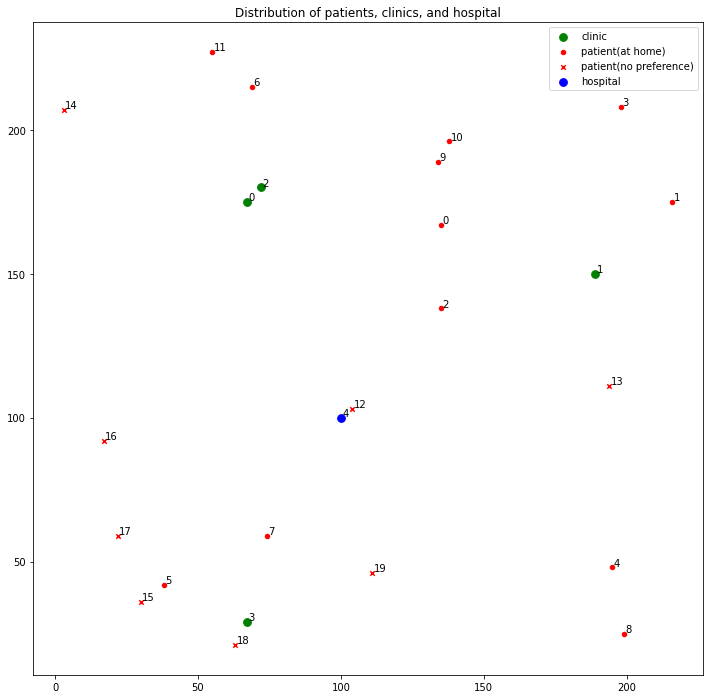

In [62]:
gurobiSolve('./lowsetupfeeData/', 'data/', '20/1', False, False) # True: social welfare, True, cost

In [61]:
def writeFile():
    f = open(path, "w+")
    f.write('Time: {} \n'.format(time))
    f.write('Objective value: {} \n'.format(obj))
    
    f.write("\n")
    f.write("==============================================================================")
    temp = 'Open clinic: '
    for i in range(numc):
        if z[i].X > 0:
            temp += str(i) + ' '
    temp += '\n'
    f.write(temp)
    
    f.write("\n")
    f.write("==============================================================================")
    f.write('Nurse Assignment: \n')
    f.write('  -> Visiting Nurse Assignment: \n')
    
    
    for i in range(numc):
        for k in range(numvr):
            if p1[i, k].X >0:
                f.write('    Visiting nurse {} is assigned to clinic {}. \n'.format(k, i))
                for j in range(nump):
                    if w1[i, j, k].X >0:
                        f.write('      Patient {} is assigned to visiting nurse {} in clinic {}. \n'.format(j, k, i))
                        f.write('        Starting time for patient {} is {};'.format(j, s1[j, k]))
                    flag = False
                    for j2 in range(nump):
                        if x1[i, j, j2, k].X > 0:
                            f.write('        From patient {} to patient {}.\n'.format(j, j2))
                            flag = True
                        if flag == False:
                            f.write('\n')
                        
            
            
    f.write('  -> Clinic Nurse Assignment: \n')
    for i in range(numc):
        for k in range(numnr):
            if p2[i, j].X >0:
                f.write('    Clinic nurse {} is assigned to clinic {}. \n'.format(k, i))
                for j in range(nump2):
                    if w2[i, j, k].X >0:
                        f.write('      Patient {} is assigned to clinic nurse {} in clinic {}. \n'.format(j, k, i))
                        f.write('        Starting time for patient {} is {};'.format(k, s1[j, k]))
                        flag = False
                        for j2 in range(nump2):
                            if x2[i, j, j2, k].X > 0:
                                f.write('        From patient {} to patient {}.\n'.format(j, j2))
                                flag = True
                        if flag == False:
                            f.write('\n')
                        
            
            
    f.write('  -> Hospital Nurse Assignment: \n')
    for k in range(numvr):
        if p3[k].X >0:
            f.write('    Hospital nurse {} is assigned to hospital. \n'.format(k))
            for j in range(nump2):
                    if w3[i, j, k].X >0:
                        f.write('      Patient {} is assigned to hospital nurse {} in hospital. \n'.format(j, k))
                        f.write('        Starting time for patient {} is {};'.format(k, s3[j, k]))
                        flag = False
                        for j2 in range(nump2):
                            if x3[j, j2, k].X > 0:
                                f.write('        From patient {} to patient {}.\n'.format(j, j2))
                                flag = True
                        if flag == False:
                            f.write('\n')
    
    
    
    
    f.close()
    
    

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 2564 rows, 5486 columns and 11264 nonzeros
Model fingerprint: 0xa989c215
Variable types: 100 continuous, 5386 integer (5386 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [4e+01, 1e+03]
  Bounds range     [4e-01, 1e+01]
  RHS range        [1e+00, 1e+05]
Presolve removed 1922 rows and 4655 columns
Presolve time: 0.06s
Presolved: 642 rows, 831 columns, 3158 nonzeros


<ipython-input-14-d53bb1d22428>:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Variable types: 28 continuous, 803 integer (803 binary)

Root relaxation: objective 2.498163e+03, 479 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2498.16255    0   94          - 2498.16255      -     -    0s
H    0     0                    4572.4247451 2498.16255  45.4%     -    0s
H    0     0                    4375.8099984 2498.16255  42.9%     -    0s
     0     0 2757.04526    0   42 4375.81000 2757.04526  37.0%     -    0s
     0     0 2993.28113    0  153 4375.81000 2993.28113  31.6%     -    0s
H    0     0                    4281.6602145 2993.28113  30.1%     -    0s
     0     0 2997.04399    0  150 4281.66021 2997.04399  30.0%     -    0s
     0     0 3334.85725    0  107 4281.66021 3334.85725  22.1%     -    0s
     0     0 3334.85725    0  110 4281.66021 3334.85725  22.1%     -    0s
     0     0 3449.94076    0  104 4281.66021 3

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

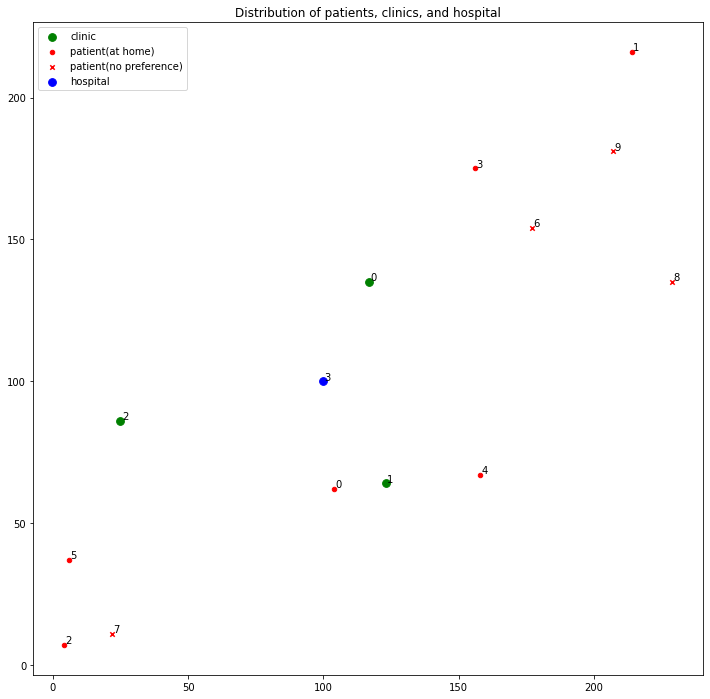

<Figure size 432x288 with 0 Axes>

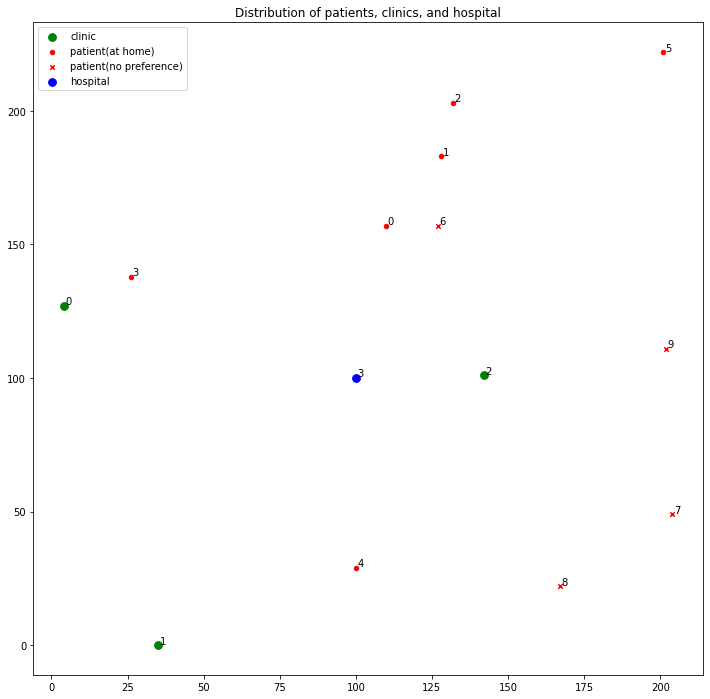

<Figure size 432x288 with 0 Axes>

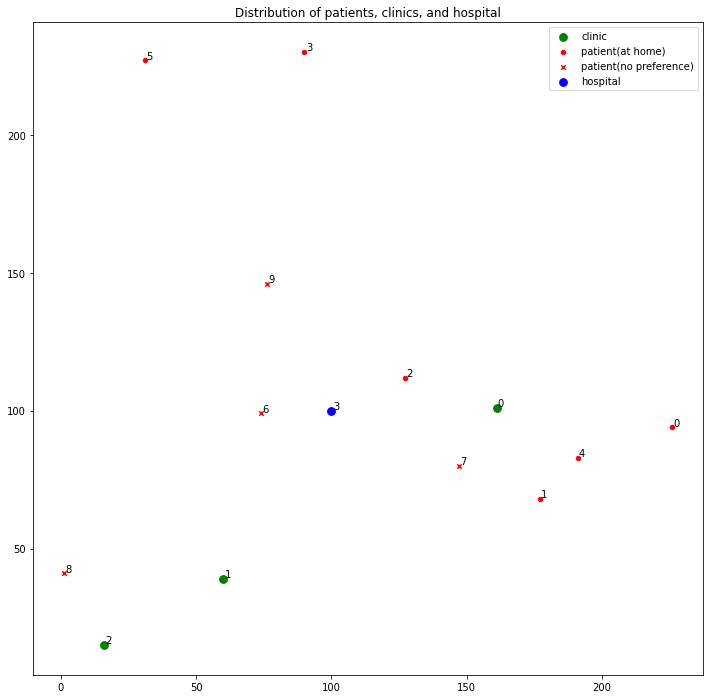

<Figure size 432x288 with 0 Axes>

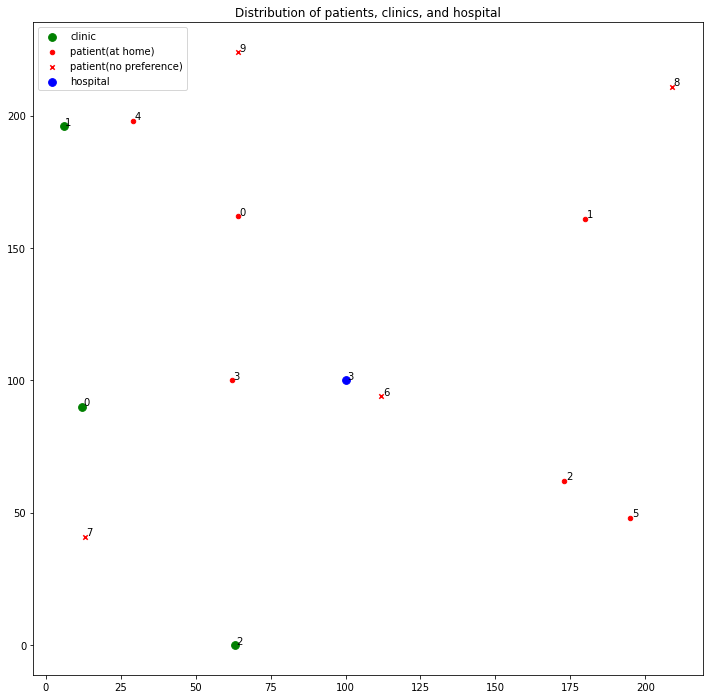

In [18]:
res_sol = []
res_time = []

L = [10, 20, 30, 40, 50]
#L = [40, 50]
for first in L:
    temp_res_sol = []
    temp_res_time = []
    for second in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
        file = str(first) + '/' + str(second)
        
        opt, duration = gurobiSolve(file)
        temp_res_sol.append(opt)
        temp_res_time.append(duration)

    res_sol.append(temp_res_sol)
    res_time.append(temp_res_time)
#gurobiSolve('10/2')

# Useless


In [169]:
with open('./data/' + name + '.txt') as f:
    numc = int(next(f).split()[0])
    nump1 = int(next(f).split()[0])
    nump2 = int(next(f).split()[0])
    numvr = int(next(f).split()[0])
    numnr = int(next(f).split()[0])
    numhr = int(next(f).split()[0])
    nump = nump1 + nump2
    
    data = []
    for line in f:
        data.append([float(x) for x in line.split()])

In [44]:
res_time

[[0.5041310787200928,
  0.674713134765625,
  0.2886228561401367,
  0.9552431106567383,
  1.416940689086914,
  0.4050147533416748,
  1.0596039295196533,
  1.638542890548706,
  0.5195090770721436,
  0.4999396800994873],
 [6.340651035308838,
  18.41493797302246,
  3.7027411460876465,
  6.968242883682251,
  44.62911796569824,
  76.6051857471466,
  14.52718472480774,
  6.524184942245483,
  16.900562286376953,
  528.5282609462738],
 [40.52560997009277,
  398.96911430358887,
  1693.4664809703827,
  37.14417910575867,
  112.24233508110046,
  373.1704180240631,
  103.75502586364746,
  182.05671000480652,
  113.75071001052856,
  8735.1591360569]]

In [170]:
y
xc = []
yc = []
fee = []
for c in range(numc):
    xc.append(data[c][1])
    yc.append(data[c][2])
    fee.append(data[c][3])

In [171]:
salary_vr = []
for vr in range(numvr):
    salary_vr.append(data[numc + vr][2])
    
salary_nr = []
for nr in range(numnr):
    salary_nr.append(data[numc + numvr + nr][2])
    
salary_hr = []
for hr in range(numhr):
    salary_hr.append(data[numc + numvr + numnr + hr][2])

In [172]:
cur_index = numc + numvr + numnr + numhr

In [173]:
p1_x = []
p1_y = []
p1_st = []
p1_ser = []
p1_ed = []

for p1 in range(nump1):
    p1_x.append(data[cur_index + p1][2])
    p1_y.append(data[cur_index + p1][3])
    p1_ser.append(data[cur_index + p1][4])
    p1_st.append(data[cur_index + p1][5])
    p1_ed.append(data[cur_index + p1][6])

p2_x = []
p2_y = []
p2_st = []
p2_ser = []
p2_ed = []

cur_index += nump1;
for p1 in range(nump2):
    p2_x.append(data[cur_index + p1][2])
    p2_y.append(data[cur_index + p1][3])
    p2_ser.append(data[cur_index + p1][4])
    p2_st.append(data[cur_index + p1][5])
    p2_ed.append(data[cur_index + p1][6])

px = p1_x + p2_x
py = p1_y + p2_y
st = p1_st + p2_st
ed = p1_ed + p2_ed
ser = p1_ser + p2_ser

pcx = px + xc
pcy = py + yc

In [176]:
numc1 = numc - 1

In [84]:
for i in range(numc):
    for j1 in range(nump, nump + numc):
        for j2 in range(nump, nump + numc):
            for k in range(numvr):
                if x2[i, j1, j2, k].X > 0:
                    if j1 > nump:
                        print("seconde clinic", i, j1 - nump, j2, k)
                    elif j2 > nump:
                        print("first clinic", i, j1, j2 - nump, k)
                    else:
                        print(i, j1, j2, k)

In [127]:

temp1 = 0
temp2 = 0

i = 1
for j in range(nump1, nump):
    temp1 += x2[i, nump + i, j, 1].X
    temp2 += x2[i, j, nump + i, 1].X
print(j, temp1, p2[i, 1].X)
print(j, temp2, p2[i, 1].X)

9 1.0 1.0
9 1.0 1.0


In [119]:
p2[1, 1].X

1.0

In [154]:
for j1 in range(nump + numc):
    for j2 in range(nump + numc):
        if x2[0, j1, j2, 0].X > 0:
            print(j1, j2, k)

6 10 4
8 6 4
10 8 4


In [152]:
for i in range(numc):
    for k in range(numnr):
        if p2[i, k].X > 0:
            print(i, k)

0 0


In [115]:
for i in range(numc):
    for j in range(nump):
        for k in range(numnr):
            if w2[i, j, k].X > 0:
                print(i, j, k)

1 6 1
1 8 1


In [155]:
for j in range(nump):
    for k in range(numhr):
        if w3[j, k].X > 0:
            print(j, k)

In [72]:
print(st[8], ed[8], ser[8])
print(st[5], ed[5], ser[5])
print(st[7], ed[7], ser[7])


4.14 5.89 0.23
10.37 12.0 0.25
5.33 7.1 0.26


In [156]:

for k in range(numhr):
    if p3[k].X > 0:
        print(k)

In [82]:
for i in range(numc):
    for k in range(numnr):
        temp1 = 0
        temp2 = 0
        for j in range(nump1, nump):
            temp1 += x2[i, nump + i, j, k].X
            temp2 += x2[i, j, nump + i, k].X
        print(i, k, ": ", temp1, temp2)

0 0 :  0.0 0.0
0 1 :  0.0 0.0
0 2 :  0.0 0.0
0 3 :  0.0 0.0
0 4 :  0.0 0.0
1 0 :  0.0 0.0
1 1 :  0.0 0.0
1 2 :  0.0 0.0
1 3 :  0.0 0.0
1 4 :  0.0 0.0
2 0 :  0.0 0.0
2 1 :  0.0 0.0
2 2 :  0.0 0.0
2 3 :  0.0 0.0
2 4 :  0.0 0.0
3 0 :  0.0 0.0
3 1 :  0.0 0.0
3 2 :  0.0 0.0
3 3 :  0.0 0.0
3 4 :  0.0 0.0


In [40]:
def travel(j1, j2):
    return (((px[j1] - px[j2])**2 + (py[j1] - py[j2])**2)**0.02)

def travelc(j1, j2):
    return (((pcx[j1] - pcx[j2])**2 + (pcy[j1] - pcy[j2])**2)**2.2)

In [177]:
mo = Model("nvrp")
z = {}
for i in range(numc):
    z[i] = mo.addVar(vtype = GRB.BINARY, name="z[%s]" %(i))

p1 = {}
for i in range(numc):
    for k in range(numvr):
        p1[i, k] = mo.addVar(vtype = GRB.BINARY, name="p1[%s,%s]" %(i,k))

p2 = {}
for i in range(numc):
    for k in range(numnr):
        p2[i, k] = mo.addVar(vtype = GRB.BINARY, name="p2[%s,%s]" %(i,k))   
        
p3 = {}
for i in range(numhr):
    p3[i] = mo.addVar(vtype = GRB.BINARY, name="p3[%s]" %(i))  
    
w1 = {}
for i in range(numc):
    for j in range(nump):
        for k in range(numvr):
            w1[i, j, k] = mo.addVar(vtype = GRB.BINARY, name="w1[%s,%s,%s]" %(i,j,k))
        
w2 = {}
for i in range(numc):
    for j in range(nump):
        for k in range(numnr):
            w2[i, j, k] = mo.addVar(vtype = GRB.BINARY, name="w2[%s,%s,%s]" %(i,j,k))
            
w3 = {}
for j in range(nump):
    for k in range(numhr):
        w3[j, k] = mo.addVar(vtype = GRB.BINARY, name="w3[%s,%s]" %(j,k))
        
s1 = {}
for j in range(nump):
    for k in range(numvr):
        s1[j, k] = mo.addVar(lb = st[j], ub = ed[j], vtype = GRB.CONTINUOUS, name="s1[%s,%s]" %(j,k))
        
s2 = {}
for j in range(nump):
    for k in range(numnr):
        s2[j, k] = mo.addVar(lb = st[j], ub = ed[j], vtype = GRB.CONTINUOUS, name="s2[%s,%s]" %(j,k))
        
s3 = {}
for j in range(nump):
    for k in range(numvr):
        s3[j, k] = mo.addVar(lb = st[j], ub = ed[j], vtype = GRB.CONTINUOUS, name="s3[%s,%s]" %(j,k))
        
                

x1 = {}
for i in range(numc):
    for j1 in range(nump + numc):
        for j2 in range(nump + numc):
            for k in range(numvr):
                x1[i, j1, j2, k] = mo.addVar(vtype = GRB.BINARY, name="x1[%s,%s,%s,%s]" %(i,j1,j2,k))
        
x2 = {}
for i in range(numc):
    for j1 in range(nump + numc):
        for j2 in range(nump + numc):
            for k in range(numnr):
                x2[i, j1, j2, k] = mo.addVar(vtype = GRB.BINARY, name="x2[%s,%s,%s,%s]" %(i,j1,j2,k))

x3 = {}
for j1 in range(nump + numc):
    for j2 in range(nump + numc):
        for k in range(numhr):
            x3[j1, j2, k] = mo.addVar(vtype = GRB.BINARY, name="x3[%s,%s,%s]" %(j1,j2,k))


In [178]:
cc = {}
cc[0] = {}

for j2 in range(nump2):
    temp = 0
    for i in range(numc1):
        for k in range(numvr):
            temp += w1[i, nump1 + j2, k]
    for i in range(numc1):
        for k in range(numnr):
            temp += w2[i, nump1 + j2, k]
    for k in range(numhr):
        temp += w3[nump1 + j2, k]
    cc[0][j2] = mo.addConstr(temp == 1, name="c0_[%s]" %(j2))
    
cc[1] = {}
for j1 in range(nump1):
    temp = 0
    for i in range(numc1):
        for k in range(numvr):
            temp += w1[i, j1, k]
    cc[1][j1] = mo.addConstr(temp == 1, name="c1_[%s]" %(j1))
    
cc[2] = {}
for k in range(numvr):
    temp = 0
    for i in range(numc1):
        temp += p1[i, k]
    cc[2][k] = mo.addConstr(temp <= 1, name="c2_[%s]" %(k))
    
cc[3] = {}
for k in range(numnr):
    temp = 0
    for i in range(numc1):
        temp += p2[i, k]
    cc[3][k] = mo.addConstr(temp <= 1, name="c3_[%s]" %(k))
    
    
cc[4] = {}
for k in range(numhr):
    cc[4][k] = mo.addConstr(p3[k] <= 1, name="c4_[%s]" %(k))
    
cc[5] = {}
for i in range(numc1):
    for k in range(numvr):
        cc[5][i, k] = mo.addConstr(p1[i, k] <= z[i], name="c5_[%s,%s]" %(i, k))
        
cc[6] = {}
for i in range(numc1):
    for k in range(numnr):
        cc[6][i, k] = mo.addConstr(p2[i, k] <= z[i],  name="c6_[%s,%s]" %(i, k))
        
cc[7] = {}
for i in range(numc1):
    for j in range(nump):
        for k in range(numvr):
            cc[7][i, j, k] = mo.addConstr(w1[i, j, k] <= p1[i, k], name="c7_[%s,%s,%s]" %(i, j, k))

cc[8] = {}
for i in range(numc1):
    for j in range(nump1, nump):
        for k in range(numnr):
            cc[8][i, j, k] = mo.addConstr(w2[i, j, k] <= p2[i, k], name="c8_[%s,%s,%s]" %(i, j, k))   
            
cc[9] = {}
for j in range(nump1, nump):
    for k in range(numhr):
        cc[9][j, k] = mo.addConstr(w3[j, k] <= p3[k], name="c9_[%s,%s]" %(j, k))
        
cc[10] = {}
for i in range(numc1):
    for k in range(numnr):
        temp = 0
        for j in range(nump2):
            temp += p2_ser[j] * w2[i, nump1 + j, k]
        cc[10][i, k] = mo.addConstr(temp <= 12, name="c10_[%s,%s]" %(i, k))
        
        
cc[11] = {}
for k in range(numhr):
    temp = 0
    for j in range(nump2):
        temp += p2_ser[j] * w3[nump1 + j, k]
    cc[11][k] = mo.addConstr(temp <= 12, name="c11_[%s,%s]" %(j, k))

    
cc[12] = {}
for i in range(numc1):
    for j1 in range(nump):
        for k in range(numvr):
            temp = 0
            for j2 in range(nump + numc1):
                if j2 != j1:
                    temp += x1[i, j1, j2, k]
            cc[12][i, j1, k] = mo.addConstr(temp == w1[i, j1, k], name="c12_[%s,%s,%s]" %(i, j1, k))

            
cc[121] = {}
for i in range(numc1):
    for j1 in range(nump):
        for k in range(numvr):
            temp = 0
            for j2 in range(nump + numc1):
                if j2 != j1:
                    temp += x1[i, j2, j1, k]
            cc[121][i, j1, k] = mo.addConstr(temp == w1[i, j1, k], name="c121_[%s,%s,%s]" %(i, j1, k))            
            
            
cc[13] = {}
for i in range(numc1):
    for j1 in range(nump1, nump):
        for k in range(numnr):
            temp = 0
            for j2 in range(nump1, nump + numc1):
                if j2 != j1:
                    temp += x2[i, j1, j2, k]
            cc[13][i, j1, k] = mo.addConstr(temp == w2[i, j1, k], name="c13_[%s,%s,%s]" %(i, j1, k))
            

cc[131] = {}
for i in range(numc1):
    for j1 in range(nump1, nump):
        for k in range(numnr):
            temp = 0
            for j2 in range(nump1, nump + numc1):
                if j2 != j1:
                    temp += x2[i, j2, j1, k]
            cc[131][i, j1, k] = mo.addConstr(temp == w2[i, j1, k], name="c131_[%s,%s,%s]" %(i, j1, k))
            

# set 0
for i in range(numc):
    for j1 in range(nump, nump + numc):
        for j2 in range(nump, nump + numc):
            for k in range(numnr):            
                mo.addConstr(x2[i, j1, j2, k] == 0, name="c13_[%s,%s,%s]" %(i, j1, k))
                

cc[14] = {}
for j1 in range(nump1, nump):
    for k in range(numhr):
        temp = 0
        for j2 in range(nump1, nump):
            if j2 != j1:
                temp += x3[j1, j2, k]
        cc[14][j1, k] = mo.addConstr(temp == w3[j1, k], name="c14_[%s,%s]" %(j1, k))

cc[141] = {}
for j1 in range(nump1, nump):
    for k in range(numhr):
        temp = 0
        for j2 in range(nump1, nump):
            if j2 != j1:
                temp += x3[j2, j1, k]
        cc[141][j1, k] = mo.addConstr(temp == w3[j1, k], name="c141_[%s,%s]" %(j1, k))
        
        
cc[15] = {}
for i in range(numc1):
    for k in range(numvr):
        for j in range(nump):
            temp1 = x1[i, nump + i, j, k]
            temp2 = x1[i, j, nump + i, k]
            for j1 in range(nump):
                temp1 += x1[i, j1, j, k]
            for j2 in range(nump):
                temp2 += x1[i, j, j2, k]
            cc[15][i, j1, k] = mo.addConstr(temp1 == temp2, name="c15_[%s,%s,%s]" %(i, j1, k))       
            
cc[16] = {}
for i in range(numc1):
    for k in range(numnr):
        for j in range(nump1, nump):
            temp1 = x2[i, nump + i, j, k]
            temp2 = x2[i, j, nump + i, k]
            for j1 in range(nump1, nump):
                if j1 != j:
                    temp1 += x2[i, j1, j, k]
            for j2 in range(nump1, nump):
                if j2 != j:
                    temp2 += x2[i, j, j2, k]
            cc[16][i, j1, k] = mo.addConstr(temp1 == temp2, name="c16_[%s,%s,%s]" %(i, j1, k))   
            
    
cc[17] = {}
for k in range(numhr):
    for j in range(nump1, nump):
        temp1 = x3[nump + numc1, j, k]
        temp2 = x3[j, nump + numc1, k]
        for j1 in range(nump1, nump):
            if j1 != j:
                temp1 += x3[j1, j, k]
        for j2 in range(nump1, nump):
            if j2 != j:
                temp2 += x3[j, j2, k]
        cc[17][j1, k] = mo.addConstr(temp1 == temp2, name="c17_[%s,%s]" %(j1, k))   
    
cc[18] = {} # depot in flow = out flow
cc[19] = {}
for i in range(numc1):
    for k in range(numvr):
        temp1 = 0
        temp2 = 0
        for j in range(nump):
            temp1 += x1[i, nump + i, j, k]
            temp2 += x1[i, j, nump + i, k]

            for ii in range(numc1):
                if ii != i:
                    mo.addConstr(x1[i, nump + ii, j, k] == 0, name="c18_[%s,%s]" %(i, k)) # *
                    mo.addConstr(x1[i, j, nump + ii, k] == 0, name="c18_[%s,%s]" %(i, k)) # *
        
        cc[18][i, k] = mo.addConstr(temp1 == p1[i, k], name="c18_[%s,%s]" %(i, k))  
        cc[19][i, k] = mo.addConstr(temp2 == p1[i, k], name="c19_[%s,%s]" %(i, k)) 

          
cc[20] = {}
cc[21] = {}
for i in range(numc1):
    for k in range(numnr):
        temp1 = 0
        temp2 = 0
        for j in range(nump1, nump):
            temp1 += x2[i, nump + i, j, k]
            temp2 += x2[i, j, nump + i, k]
            
            for ii in range(numc1):
                if ii != i:
                    mo.addConstr(x2[i, nump + ii, j, k] == 0, name="c18_[%s,%s]" %(i, k)) # *
                    mo.addConstr(x2[i, j, nump + ii, k] == 0, name="c18_[%s,%s]" %(i, k)) # *
                
        cc[20][i, k] = mo.addConstr(temp1 == p2[i, k], name="c20_[%s,%s]" %(i, k))  
        cc[21][i, k] = mo.addConstr(temp2 == p2[i, k], name="c21_[%s,%s]" %(i, k)) 
        

cc[22] = {}
cc[23] = {}

for k in range(numhr):
    temp1 = 0
    temp2 = 0
    for j in range(nump1, nump):
        temp1 += x3[nump + numc1, j, k]
        temp2 += x3[j, nump + numc1, k]
    cc[22][i, k] = mo.addConstr(temp1 == p3[k], name="c22_[%s,%s]" %(i, k))  # *
    cc[23][i, k] = mo.addConstr(temp2 == p3[k], name="c23_[%s,%s]" %(i, k))  # *
        
    
cc[24] = {}
for i in range(numc1):
    for j1 in range(nump):
        for j2 in range(nump):
            if j1 != j2:
                for k in range(numvr):
                    cc[24][i, j1, j2, k] = mo.addConstr(s1[j1, k] + travel(j1, j2) + ser[j1] - 
                                                    12 * (1 - x1[i, j1, j2, k]) <= s1[j2, k],  name="c24_[%s,%s,%s,%s]" %(i, j1,j2, k))                      

cc[25] = {}
for i in range(numc1):
    for j1 in range(nump1, nump):
        for j2 in range(nump1, nump):
            if j2 != j1:
                for k in range(numnr):
                    cc[25][i, j1, j2, k] = mo.addConstr(s2[j1, k] + ser[j1] - 
                                                    12 * (1 - x2[i, j1, j2, k]) <= s2[j2, k],  name="c25_[%s,%s,%s,%s]" %(i, j1,j2, k))                      

                    
cc[26] = {}
for j1 in range(nump1, nump):
    for j2 in range(nump1, nump):
        if j2 != j1:
            for k in range(numhr):
                cc[26][j1, j2, k] = mo.addConstr(s3[j1, k] + ser[j1] - 
                                                12 * (1 - x3[j1, j2, k]) <= s3[j2, k],  name="c26_[%s,%s,%s]" %(j1,j2, k))                      
               
           
            
cc[27] = {}
for i in range(numc1):
    for k in range(numvr):
        temp = 0
        for j1 in range(nump1 + numc):
            for j2 in range(nump1 + numc):
                if j2 != j1:
                    temp += travel(j1, j2) * x1[i, j1, j2, k]
        for j in range(nump):
            temp += ser[j] * w1[i, j, k]
        
        cc[27][i, k] = mo.addConstr(temp <= 12, name="c27_[%s,%s]" %(i, k))
        

In [327]:
        


            
cc[18] = {} # depot in flow = out flow
cc[19] = {}
for i in range(numc1):
    for k in range(numvr):
        temp1 = 0
        temp2 = 0
        for j in range(nump):
            temp1 += x1[i, nump + i, j, k]
            temp2 += x1[i, j, nump + i, k]
        cc[18][i, k] = mo.addConstr(temp1 == p1[i, k], name="c18_[%s,%s]" %(i, k))  
        cc[19][i, k] = mo.addConstr(temp2 == p1[i, k], name="c19_[%s,%s]" %(i, k)) 

          
cc[20] = {}
cc[21] = {}
for i in range(numc1):
    for k in range(numnr):
        temp1 = 0
        temp2 = 0
        for j in range(nump1, nump):
            temp1 += x2[i, nump + i, j, k]
            temp2 += x2[i, j, nump + i, k]
        cc[20][i, k] = mo.addConstr(temp1 == p2[i, k], name="c20_[%s,%s]" %(i, k))  
        cc[21][i, k] = mo.addConstr(temp2 == p2[i, k], name="c21_[%s,%s]" %(i, k)) 
        
        
cc[22] = {}
cc[23] = {}

for k in range(numhr):
    temp1 = 0
    temp2 = 0
    for j in range(nump1, nump):
        temp1 += x3[nump + numc1, j, k]
        temp2 += x3[j, nump + numc1, k]
    cc[22][i, k] = mo.addConstr(temp1 == p3[k], name="c22_[%s,%s]" %(i, k))  
    cc[23][i, k] = mo.addConstr(temp2 == p3[k], name="c23_[%s,%s]" %(i, k)) 
           

        
                

        

In [179]:

temp = 0
for i in range(numc):
    temp += fee[i] * z[i]
    for k in range(numvr):
        temp += salary_vr[k] * p1[i, k]
    for k in range(numnr):
        temp += salary_nr[k] * p2[i, k]
for k in range(numhr):
    temp += salary_hr[k] * p3[k]
    
for i in range(numc):
    for k in range(numvr):
        for j1 in range(nump + numc):
            for j2 in range(nump + numc):
                if j2 != j1:
                    temp += travelc(j1, j2) * x1[i, j1, j2, k]
obj = temp

In [180]:
mo.update()
mo.setObjective(obj, GRB.MINIMIZE) 
mo.optimize()
#mo.feasRelaxS(1, True, False, True);

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 4130 rows, 9469 columns and 18565 nonzeros
Model fingerprint: 0x83c5246d
Variable types: 150 continuous, 9319 integer (9319 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+01]
  Objective range  [3e+02, 4e+10]
  Bounds range     [6e-01, 1e+01]
  RHS range        [1e+00, 1e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2865 rows and 7841 columns
Presolve time: 0.07s
Presolved: 1265 rows, 1628 columns, 7290 nonzeros
Variable types: 55 continuous, 1573 integer (1573 binary)
Found heuristic solution: objective 5.766559e+10

Root relaxation: objective 7.226948e+09, 698 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  

In [194]:
temp = 0
for i in range(numc):
    temp += fee[i] * z[i].X
    for k in range(numvr):
        temp += salary_vr[k] * p1[i, k].X
    for k in range(numnr):
        temp += salary_nr[k] * p2[i, k].X
for k in range(numhr):
    temp += salary_hr[k] * p3[k].X
print(temp)

1230.66


In [139]:
mo.write("bi.lp")